### Shape-Similarity_Search_of_Three_Dimensional_Models_Using_Parameterized_Statistics

###Introduction
We  try to create a similar form of similarity search application to the one described in the article 'Shape-Similarity Search of Three-Dimensional Models Using Parameterized Statistics'.
https://www.researchgate.net/publication/3998806_Shape-Similarity_Search_of_Three-Dimensional_Models_Using_Parameterized_Statistics

In order to process the 3D models and extract form features, we also used libraries like sklearn and trimesh.
We employed normalizing techniques to ensure that models are compared equally and the dissimilarity calculation approach given in the paper to measure shape similarity.




On a 3D model database called "3DPotteryDataset," we evaluated our application, and the shape similarity results were encouraging. To make our program more effective and dependable for actual use, however, there are still modifications to be required.

In [ ]:
! pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.9/670.9 KB 12.6 MB/s eta 0:00:00


In [ ]:
! wget http://www.ipet.gr/~akoutsou/benchmark/dataset/3DPotteryDataset_v_1.zip


--2023-01-20 23:56:23--  http://www.ipet.gr/~akoutsou/benchmark/dataset/3DPotteryDataset_v_1.zip
Resolving www.ipet.gr (www.ipet.gr)... 195.251.3.14
Connecting to www.ipet.gr (www.ipet.gr)|195.251.3.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247316844 (236M) [application/x-zip-compressed]
Saving to: ‘3DPotteryDataset_v_1.zip’

3DPotteryDataset_v_ 100%[===================>] 235.86M  7.29MB/s    in 27s     

2023-01-20 23:56:51 (8.81 MB/s) - ‘3DPotteryDataset_v_1.zip’ saved [247316844/247316844]



In [ ]:
! unzip /content/3DPotteryDataset_v_1


In [ ]:
import trimesh
from scipy.spatial import distance
import numpy as np
import os

# Load the 3D model
mesh1 = trimesh.load_mesh('/content/3D Models/Abstract/Abstractshape1.obj')



## Get Features from .obj files

methode 1 : The function get_features below  calculates various features of a 3D mesh that we give, such as the **moment of inertia**, **average distance**, and **variance of distance**, then returns them as a single feature vector.

 It uses the eigenvalues and eigenvectors of the inertia tensor of the mesh to determine its principal axes.

In [ ]:

def get_features(your_mesh):

  inertia_tensor = your_mesh.moment_inertia
  evals, evecs = np.linalg.eig(inertia_tensor)

  # Create an empty list to store the shape feature vectors
  shape_features = []

  # Iterate over the principal axes
  for axis in evecs:
      # Compute the dot product of the vertex normals with the axis to get the distance
      distances = np.dot(your_mesh.vertex_normals, axis)

      # Compute the moment of inertia about the axis
      moment_inertia = np.dot(distances, distances)
      # print(moment_inertia)

      # Compute the average distance
      average_distance = np.mean(distances)
      # print(average_distance)

      # Compute the variance of distance
      variance_distance = np.var(distances)
      # print(variance_distance)

      feature_vector = [moment_inertia, average_distance, variance_distance]
      shape_features.append(feature_vector)

  # Concatenate the 9 feature vectors into a single feature vector
  shape_features = np.concatenate(shape_features)

  return shape_features

In [ ]:
print(get_features(mesh1))

[2.35040065e+02 1.18991386e-01 2.21116391e-01 3.82801962e+02
 1.71655501e-02 3.82890491e-01 3.81158011e+02 5.50814403e-03
 3.81509211e-01]


methode 2 : This function loads a 3D mesh, segments it into 15 slabs, computes statistics for each slab, normalizes the feature vector and calculates dissimilarity.
It returns the feature vector and dissimilarity.

In [ ]:
def get_feature_vector(file_path):
    # Load the mesh
    mesh = trimesh.load_mesh(file_path)

    # Get the principal axes of inertia
    inertia_tensor = mesh.moment_inertia
    eigenvalues, eigenvectors = np.linalg.eig(inertia_tensor)

    # Set the number of slabs
    l = 15

    # Initialize the feature vector
    feature_vector = []

    # Iterate over the principal axes
    for axis in eigenvectors:
        # Initialize the axis feature vector
        axis_feature_vector = []

        # Segment the mesh into l equal thickness slabs along the axis
        min_coord = np.min(np.dot(mesh.vertices, axis))
        max_coord = np.max(np.dot(mesh.vertices, axis))
        slab_thickness = (max_coord - min_coord) / l
        slabs = [min_coord + i * slab_thickness for i in range(l)]

        # Iterate over the analysis windows
        for i in range(l):
            # Compute the indices of the vertices in the current analysis window
            if i < l-1:
                vertex_indices = np.where(np.logical_and(np.dot(mesh.vertices, axis) >= slabs[i], np.dot(mesh.vertices, axis) < slabs[i+1]))[0]
            else:
                vertex_indices = np.where(np.dot(mesh.vertices, axis) >= slabs[i])[0]

            # Compute the statistics for the current analysis window
            moment_inertia = np.dot(np.dot(mesh.vertices[vertex_indices], axis), np.dot(mesh.vertices[vertex_indices], axis))
            average_distance = np.mean(np.dot(mesh.vertices[vertex_indices], axis))
            variance_distance = np.var(np.dot(mesh.vertices[vertex_indices], axis))
            # Append the statistics to the axis feature vector
            axis_feature_vector.append([moment_inertia, average_distance, variance_distance])

        # Append the axis feature vector to the overall feature vector
        feature_vector.append(axis_feature_vector)
    # Normalize the feature vector
    feature_vector = (feature_vector - np.mean(feature_vector)) / np.std(feature_vector)

    # Compute the dissimilarity between the shape features using Euclidean distances between the feature vectors of the three principal axes
    dissimilarity = np.linalg.norm(feature_vector[0] - feature_vector[1]) + np.linalg.norm(feature_vector[0] - feature_vector[2]) + np.linalg.norm(feature_vector[1] - feature_vector[2])

    # Return the feature vector, dissimilarity
    return feature_vector, dissimilarity


In [ ]:
import matplotlib.pyplot as plt

def plot_stats(feature_vector):
    ax_list = [0, 1, 2]
    stat_list = ['moment_inertia', 'average_distance', 'variance_distance']
    # Iterate over the axes
    for i in range(len(ax_list)):
        ax = ax_list[i]
        fig = plt.figure()
        # Iterate over the statistics
        for j in range(len(stat_list)):
            stat = stat_list[j]
            plt.plot(feature_vector[ax][:, j], label=stat)
        plt.legend()
        plt.xlabel('Analysis Windows')
        plt.title('Parameterized Statistics along Axis {0}'.format(i))
    
    plt.show()

In [ ]:
import matplotlib.pyplot as plt 
import os 

def display_jpeg_images_relative_dir(obj_file_path, jpeg_relative_dir):
    # Get the base directory 
    obj_name = os.path.splitext(os.path.basename(obj_file_path))[0];
    base_dir = os.path.dirname(obj_file_path)
    # print(base_dir)
    
    # Get the absolute path to the 'Thumbnails' directory
    thumbnail_dir = base_dir.replace('3D Models','Thumbnails')

    # Get the paths of all JPEG images
    jpeg_files_paths = [os.path.join(thumbnail_dir, f) for f in os.listdir(thumbnail_dir) if f.endswith(".jpg") and os.path.splitext(os.path.basename(f))[0].lower() == obj_name.lower()]
    print(jpeg_files_paths)
    # Iterate through JPEG images
    for jpeg_file_name in jpeg_files_paths:
        # Read the JPEG image 
        img = plt.imread(jpeg_file_name)
        # Display the JPEG image 
        plt.imshow(img)
        plt.show()


(array([[[ 0.59158619, -0.37986333, -0.37952686],
        [ 0.89264415, -0.37983133, -0.37951647],
        [ 0.83579775, -0.37979981, -0.37951789],
        [ 0.52021331, -0.3797681 , -0.37950897],
        [ 0.24983447, -0.37973784, -0.37952249],
        [ 0.84105227, -0.37970704, -0.37952762],
        [ 0.06591196, -0.37967748, -0.37950829],
        [-0.31643994, -0.37964708, -0.37951578],
        [-0.36139616, -0.3796174 , -0.37951811],
        [-0.14086584, -0.37958543, -0.37950384],
        [ 0.44725806, -0.37955335, -0.37951165],
        [ 1.50822494, -0.37952352, -0.37952022],
        [ 1.98507242, -0.3794972 , -0.37953604],
        [ 0.8668973 , -0.37946215, -0.3795226 ],
        [ 0.71220436, -0.3794319 , -0.37951059]],

       [[ 4.84147891, -0.37980545, -0.37958495],
        [ 5.76818966, -0.37978717, -0.37958403],
        [ 6.20241904, -0.37976981, -0.37958925],
        [ 2.46390611, -0.37975148, -0.37958457],
        [ 0.07977862, -0.37973303, -0.37959145],
        [ 0.02384

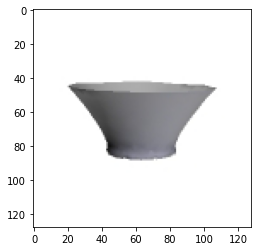

In [ ]:
print(get_feature_vector('/content/3D Models/Kalathos/Kalathos1.obj'))
fv1,ds1 = get_feature_vector('/content/3D Models/Kalathos/Kalathos1.obj')
# plot_stats(fv1)
display_jpeg_images_relative_dir('/content/3D Models/Kalathos/Kalathos1.obj', 'Thumbnails/')

(array([[[ 0.66494745, -0.32730474, -0.32699812],
        [ 0.7637724 , -0.32727856, -0.32701293],
        [ 0.80411696, -0.32725125, -0.32701143],
        [ 1.63100376, -0.3272222 , -0.32704591],
        [ 1.15226586, -0.3271982 , -0.32701774],
        [ 0.18272382, -0.32717088, -0.32702398],
        [-0.17430971, -0.32714358, -0.32700935],
        [-0.31581503, -0.32711682, -0.32701961],
        [-0.25994663, -0.32708995, -0.32702747],
        [ 0.03357962, -0.32706291, -0.32701411],
        [ 0.83629314, -0.32703573, -0.32700872],
        [ 0.48195926, -0.32701273, -0.32700728],
        [ 0.44556449, -0.32698303, -0.32701863],
        [ 0.57096311, -0.32695659, -0.32701806],
        [ 0.49532851, -0.32692991, -0.32701103]],

       [[ 0.63763338, -0.32730795, -0.32700279],
        [ 0.76031302, -0.32728176, -0.32702147],
        [ 0.7012533 , -0.32725479, -0.32700998],
        [ 0.77204672, -0.32722332, -0.32700255],
        [ 1.27957208, -0.32720011, -0.32701484],
        [ 0.25135

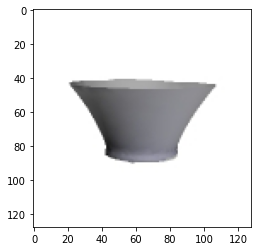

In [ ]:
print(get_feature_vector('/content/3D Models/Kalathos/Kalathos20.obj'))
fv2,ds2 = get_feature_vector('/content/3D Models/Kalathos/Kalathos20.obj')
# plot_stats(fv2)
display_jpeg_images_relative_dir('/content/3D Models/Kalathos/Kalathos20.obj', 'Thumbnails/')

In [ ]:
def compare_feature_vectors(path,treshold):
    
    file_paths = [os.path.join(d,f) for d, dirs, files in os.walk(path) for f in files]
    for f1, f2 in zip(file_paths[:-1], file_paths[1:]):
        fv1, ds1 = get_feature_vector(f1)
        fv2, ds2 = get_feature_vector(f2)
        if abs(ds2-ds1) < treshold:
            print(f"Similar Files Found: {f1},{ds1} & {f2},{ds2}")
            display_jpeg_images_relative_dir(f1,'Thumbnails/')
            display_jpeg_images_relative_dir(f2,'Thumbnails/')


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3721: RuntimeWarning: Degrees of freedom <= 0 for slice
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Similar Files Found: /content/3D Models/Abstract/qp28.obj,22.785588112087503 & /content/3D Models/Abstract/qp34.obj,22.884423062385146
['/content/Thumbnails/Abstract/Qp28.jpg']


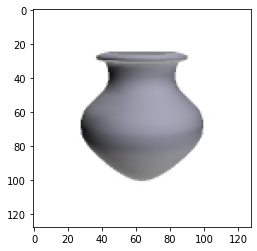

['/content/Thumbnails/Abstract/Qp34.jpg']


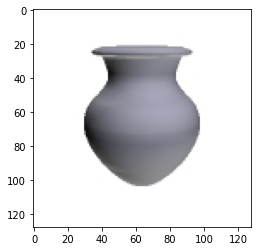

Similar Files Found: /content/3D Models/Abstract/Y2534_POTTERY7.obj,23.317431604766973 & /content/3D Models/Abstract/qp31.obj,23.073381059839534
['/content/Thumbnails/Abstract/Y2534_pottery7.jpg']


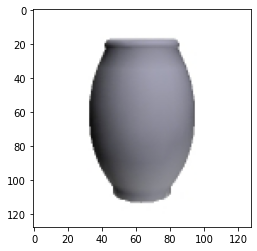

['/content/Thumbnails/Abstract/Qp31.jpg']


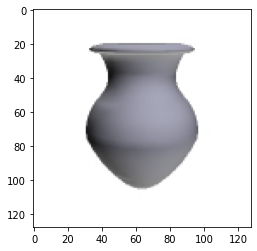

In [ ]:
treshold1 = 0.5
compare_feature_vectors("/content/3D Models/Abstract",treshold1)

In [ ]:
import trimesh
from sklearn.linear_model import ElasticNet
from sklearn.metrics import pairwise_distances

def calculate_dissimilarity(mesh1_path, mesh2_path, alpha):
    # Load the two meshes
    mesh1 = trimesh.load_mesh(mesh1_path)
    mesh2 = trimesh.load_mesh(mesh2_path)

    # Extract the vertex coordinates of the two meshes
    vertices1 = mesh1.vertices
    vertices2 = mesh2.vertices

    # Find the minimum number of vertices of the two meshes
    min_vertices = min(len(vertices1), len(vertices2))

    # Downsample the vertex coordinates of one of the meshes to match the minimum number of vertices
    if len(vertices1) > min_vertices:
        vertices1 = vertices1[:min_vertices]
    else:
        vertices2 = vertices2[:min_vertices]

    # Use ElasticNet to find the best matching transformation between the two sets of vertices
    en = ElasticNet(alpha=alpha)
    en.fit(vertices1, vertices2)
    transformed_vertices1 = en.predict(vertices1)

    # Calculate the dissimilarity as the pairwise euclidean distance between the transformed and original vertex coordinates
    dissimilarity = pairwise_distances(transformed_vertices1, vertices2).mean()

    return(dissimilarity)

In [ ]:
mesh1_path = "/content/3D Models/Bowl/London D 7.obj"
mesh2_path = "/content/3D Models/Bowl/London B 675.obj"
alpha = 0.5
dissimilarity = calculate_dissimilarity(mesh1_path, mesh2_path, alpha)
print("Dissimilarity (the lower the similar the two meshs are) :", dissimilarity)

Dissimilarity (the lower the similar the two meshs are) : 31.97385794364479


In [ ]:
import os

def compare_feature_vectors_v2(path, treshold):
    file_paths = [os.path.join(d,f) for d, dirs, files in os.walk(path) for f in files if f.endswith('.obj')]
    for f1, f2 in zip(file_paths[:-1], file_paths[1:]):
        dissimilarity = calculate_dissimilarity(f1, f2, 0.5)
        if abs(dissimilarity) < treshold:
            print(f"Similar Files Found: {f1},{f2}, dissimilarity = {dissimilarity} ")
            display_jpeg_images_relative_dir(f1,'Thumbnails/')
            display_jpeg_images_relative_dir(f2,'Thumbnails/')


Similar Files Found: /content/3D Models/Modern-Glass/Y3549_chaglass.obj,/content/3D Models/Modern-Glass/Y2528_POTTERY1.obj, dissimilarity = 0.15747002251409073 
['/content/Thumbnails/Modern-Glass/Y3549_chaglass.jpg']


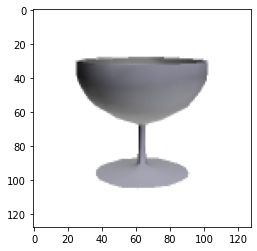

['/content/Thumbnails/Modern-Glass/Y2528_pottery1.jpg']


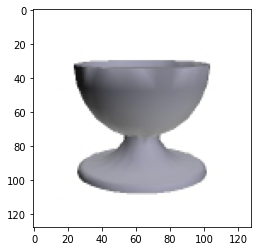

Similar Files Found: /content/3D Models/Modern-Glass/Y7974_glass1.obj,/content/3D Models/Modern-Glass/BlenderRepository_shot-glass.obj, dissimilarity = 0.19681721411578057 
['/content/Thumbnails/Modern-Glass/Y7974_glass1.jpg']


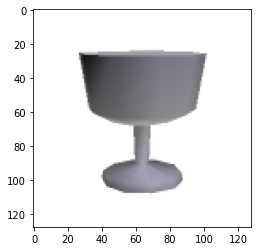

['/content/Thumbnails/Modern-Glass/Blenderrepository_shot-glass.jpg']


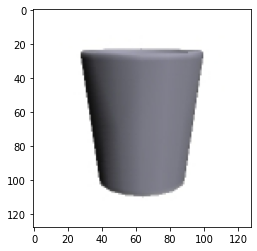

Similar Files Found: /content/3D Models/Modern-Glass/Y7848_beaker.obj,/content/3D Models/Modern-Glass/Y9226_martini.obj, dissimilarity = 0.04731752811130785 
['/content/Thumbnails/Modern-Glass/Y7848_beaker.jpg']


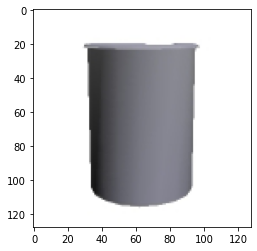

['/content/Thumbnails/Modern-Glass/Y9226_martini.jpg']


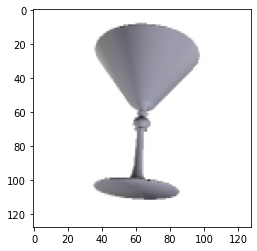

Similar Files Found: /content/3D Models/Modern-Glass/Y9226_martini.obj,/content/3D Models/Modern-Glass/Y3067_Glass.obj, dissimilarity = 0.3261031804496843 
['/content/Thumbnails/Modern-Glass/Y9226_martini.jpg']


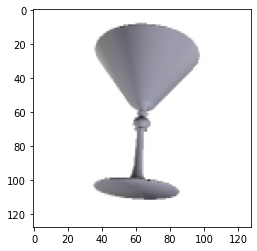

['/content/Thumbnails/Modern-Glass/Y3067_glass.jpg']


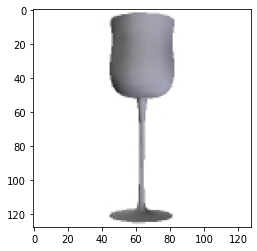

Similar Files Found: /content/3D Models/Modern-Glass/Glassn9.obj,/content/3D Models/Modern-Glass/m502.obj, dissimilarity = 0.38252056039452664 
['/content/Thumbnails/Modern-Glass/Glassn9.jpg']


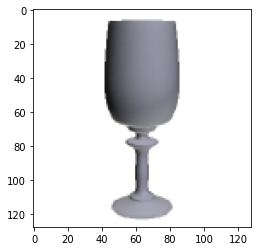

['/content/Thumbnails/Modern-Glass/M502.jpg']


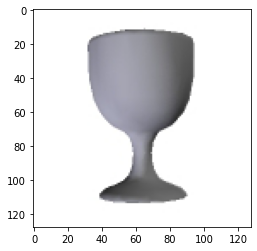

Similar Files Found: /content/3D Models/Modern-Glass/m502.obj,/content/3D Models/Modern-Glass/Y2440_GOBLET.obj, dissimilarity = 0.08717661207951305 
['/content/Thumbnails/Modern-Glass/M502.jpg']


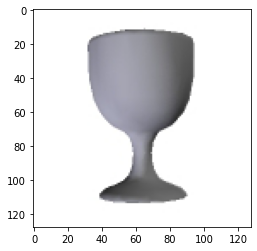

['/content/Thumbnails/Modern-Glass/Y2440_goblet.jpg']


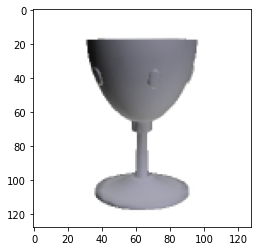

Similar Files Found: /content/3D Models/Modern-Glass/Y8979_glass1.obj,/content/3D Models/Modern-Glass/m501.obj, dissimilarity = 0.4105030626441505 
['/content/Thumbnails/Modern-Glass/Y8979_glass1.jpg']


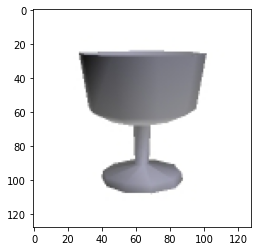

['/content/Thumbnails/Modern-Glass/M501.jpg']


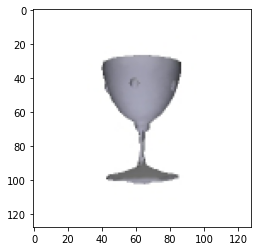

Similar Files Found: /content/3D Models/Modern-Glass/Glassn2.obj,/content/3D Models/Modern-Glass/Y2442_GRAIL.obj, dissimilarity = 0.08175987213397257 
['/content/Thumbnails/Modern-Glass/Glassn2.jpg']


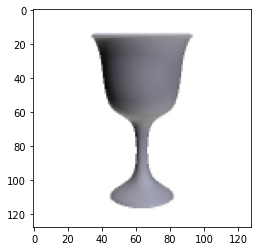

['/content/Thumbnails/Modern-Glass/Y2442_grail.jpg']


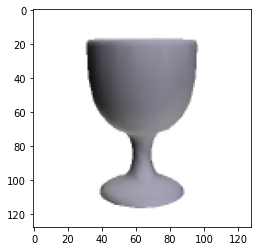

Similar Files Found: /content/3D Models/Modern-Glass/Y7979_goblet.obj,/content/3D Models/Modern-Glass/BlenderRepository_12-oz-glass.obj, dissimilarity = 0.3984167612346763 
['/content/Thumbnails/Modern-Glass/Y7979_goblet.jpg']


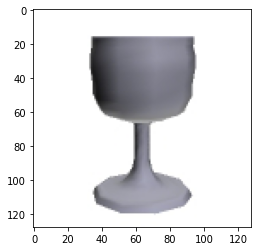

['/content/Thumbnails/Modern-Glass/Blenderrepository_12-oz-glass.jpg']


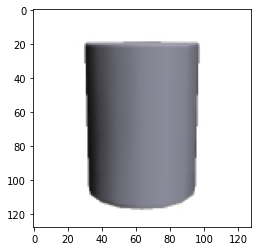

Similar Files Found: /content/3D Models/Modern-Glass/BlenderRepository_12-oz-glass.obj,/content/3D Models/Modern-Glass/Archive3D_Vase N290508.obj, dissimilarity = 0.005561096161711983 
['/content/Thumbnails/Modern-Glass/Blenderrepository_12-oz-glass.jpg']


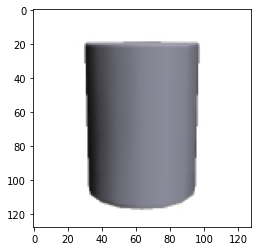

['/content/Thumbnails/Modern-Glass/Archive3d_vase n290508.jpg']


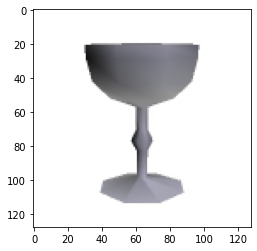

Similar Files Found: /content/3D Models/Modern-Glass/Archive3D_Vase N290508.obj,/content/3D Models/Modern-Glass/BlenderRepository_highball-glass.obj, dissimilarity = 0.4482070714167636 
['/content/Thumbnails/Modern-Glass/Archive3d_vase n290508.jpg']


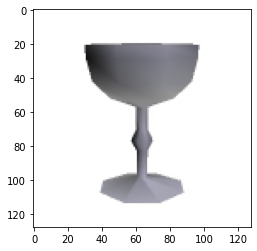

['/content/Thumbnails/Modern-Glass/Blenderrepository_highball-glass.jpg']


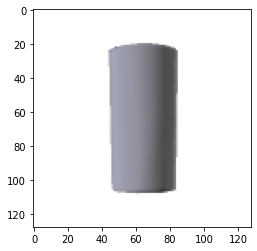

Similar Files Found: /content/3D Models/Modern-Glass/Y5100_CHAGLASS.obj,/content/3D Models/Modern-Glass/Y8985_goblet_g.obj, dissimilarity = 0.7866864649431414 
['/content/Thumbnails/Modern-Glass/Y5100_chaglass.jpg']


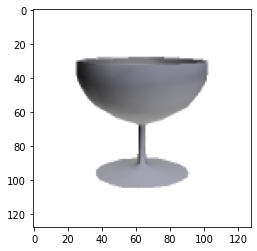

['/content/Thumbnails/Modern-Glass/Y8985_goblet_g.jpg']


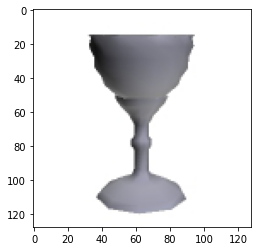

Similar Files Found: /content/3D Models/Modern-Glass/Y8985_goblet_g.obj,/content/3D Models/Modern-Glass/BlenderRepository_cocktail-glass.obj, dissimilarity = 0.28314634764058727 
['/content/Thumbnails/Modern-Glass/Y8985_goblet_g.jpg']


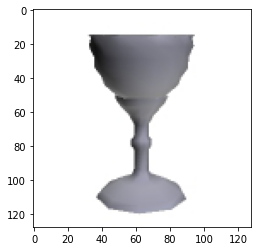

['/content/Thumbnails/Modern-Glass/Blenderrepository_cocktail-glass.jpg']


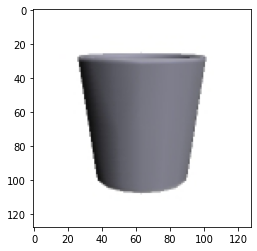

Similar Files Found: /content/3D Models/Modern-Glass/Y7976_glass3.obj,/content/3D Models/Modern-Glass/vase1s.obj, dissimilarity = 0.9804809358061026 
['/content/Thumbnails/Modern-Glass/Y7976_glass3.jpg']


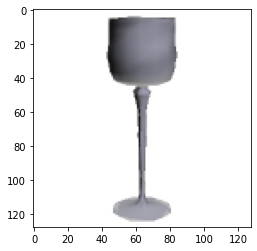

['/content/Thumbnails/Modern-Glass/Vase1s.jpg']


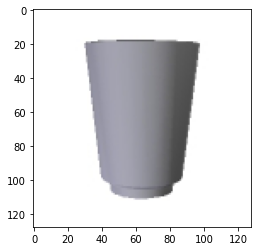

Similar Files Found: /content/3D Models/Modern-Glass/Y8079_Glass5.obj,/content/3D Models/Modern-Glass/m500.obj, dissimilarity = 0.45654258616804416 
['/content/Thumbnails/Modern-Glass/Y8079_glass5.jpg']


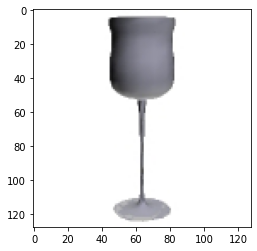

['/content/Thumbnails/Modern-Glass/M500.jpg']


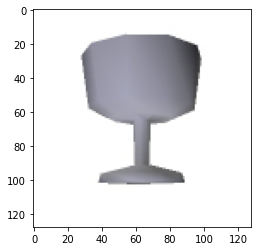

Similar Files Found: /content/3D Models/Modern-Glass/Y8980_glass2.obj,/content/3D Models/Modern-Glass/BlenderRepository_double-shot-glass.obj, dissimilarity = 0.2906021254760861 
['/content/Thumbnails/Modern-Glass/Y8980_glass2.jpg']


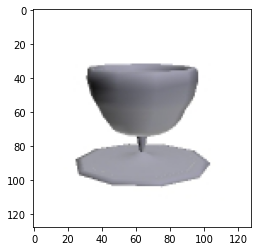

['/content/Thumbnails/Modern-Glass/Blenderrepository_double-shot-glass.jpg']


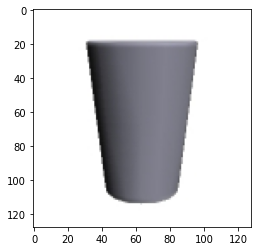

Similar Files Found: /content/3D Models/Modern-Glass/verre.obj,/content/3D Models/Modern-Glass/vase1.obj, dissimilarity = 0.9212725662012861 
['/content/Thumbnails/Modern-Glass/Verre.jpg']


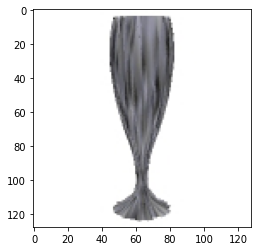

['/content/Thumbnails/Modern-Glass/Vase1.jpg']


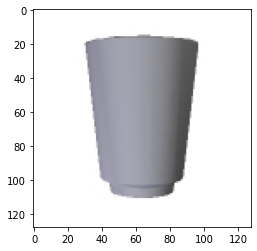

In [ ]:
treshold2 = 10
compare_feature_vectors_v2("/content/3D Models/Modern-Glass",treshold2)

In [ ]:
import trimesh
from sklearn.linear_model import ElasticNet
from sklearn.metrics import pairwise_distances

def calculate_dissimilarity_limited(mesh1_path, mesh2_path, alpha, number_vertices):
    # Load the two meshes
    mesh1 = trimesh.load_mesh(mesh1_path)
    mesh2 = trimesh.load_mesh(mesh2_path)

    # Extract the vertex coordinates (limited) of the two meshes
    vertices1 = mesh1.vertices
    vertices2 = mesh2.vertices

    # Find the minimum number of vertices of the two meshes
    min_vertices = min(len(vertices1), len(vertices2))

    if min_vertices < number_vertices :
      # Downsample the vertex coordinates of one of the meshes to match the minimum number of vertices
      if len(vertices1) > min_vertices:
          vertices1 = vertices1[:min_vertices]
      else:
          vertices2 = vertices2[:min_vertices]
    else :
      # Extract the vertex coordinates (limited) of the two meshes
      vertices1 = vertices1[:number_vertices]
      vertices2 = vertices1[:number_vertices]

    # Use ElasticNet to find the best matching transformation between the two sets of vertices
    en = ElasticNet(alpha=alpha)
    en.fit(vertices1, vertices2)
    transformed_vertices1 = en.predict(vertices1)

    # Calculate the dissimilarity as the pairwise euclidean distance between the transformed and original vertex coordinates
    dissimilarity = pairwise_distances(transformed_vertices1, vertices2).mean()

    return(dissimilarity)

In [ ]:
import os

def compare_feature_vectors_v3(path, treshold):
    file_paths = [os.path.join(d,f) for d, dirs, files in os.walk(path) for f in files if f.endswith('.obj')]
    for f1, f2 in zip(file_paths[:-1], file_paths[1:]):
        dissimilarity = calculate_dissimilarity_limited(f1, f2, 0.5,1000)
        if abs(dissimilarity) < treshold:
            print(f"Similar Files Found: {f1},{f2}, dissimilarity = {dissimilarity} ")
            display_jpeg_images_relative_dir(f1,'Thumbnails/')
            display_jpeg_images_relative_dir(f2,'Thumbnails/')

Similar Files Found: /content/3D Models/Modern-Glass/Y3549_chaglass.obj,/content/3D Models/Modern-Glass/Y2528_POTTERY1.obj, dissimilarity = 0.15747002251409073 
['/content/Thumbnails/Modern-Glass/Y3549_chaglass.jpg']


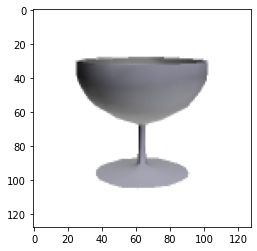

['/content/Thumbnails/Modern-Glass/Y2528_pottery1.jpg']


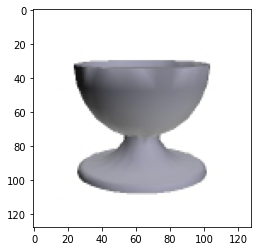

Similar Files Found: /content/3D Models/Modern-Glass/Y7974_glass1.obj,/content/3D Models/Modern-Glass/BlenderRepository_shot-glass.obj, dissimilarity = 0.19681721411578054 
['/content/Thumbnails/Modern-Glass/Y7974_glass1.jpg']


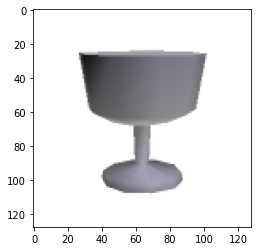

['/content/Thumbnails/Modern-Glass/Blenderrepository_shot-glass.jpg']


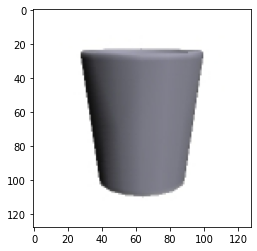

Similar Files Found: /content/3D Models/Modern-Glass/Y7848_beaker.obj,/content/3D Models/Modern-Glass/Y9226_martini.obj, dissimilarity = 0.04731752811130785 
['/content/Thumbnails/Modern-Glass/Y7848_beaker.jpg']


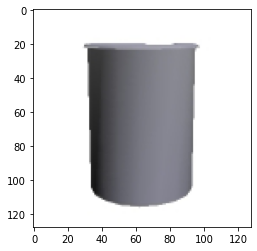

['/content/Thumbnails/Modern-Glass/Y9226_martini.jpg']


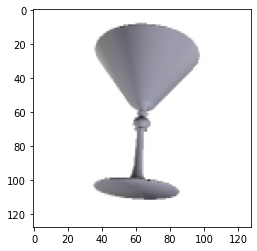

Similar Files Found: /content/3D Models/Modern-Glass/Y9226_martini.obj,/content/3D Models/Modern-Glass/Y3067_Glass.obj, dissimilarity = 0.3261031804496843 
['/content/Thumbnails/Modern-Glass/Y9226_martini.jpg']


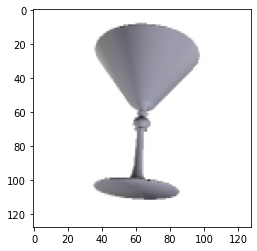

['/content/Thumbnails/Modern-Glass/Y3067_glass.jpg']


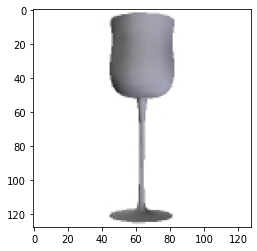

Similar Files Found: /content/3D Models/Modern-Glass/Glassn9.obj,/content/3D Models/Modern-Glass/m502.obj, dissimilarity = 0.3825205603945266 
['/content/Thumbnails/Modern-Glass/Glassn9.jpg']


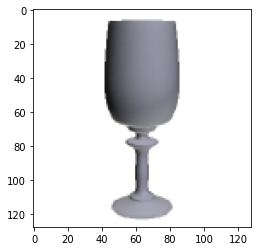

['/content/Thumbnails/Modern-Glass/M502.jpg']


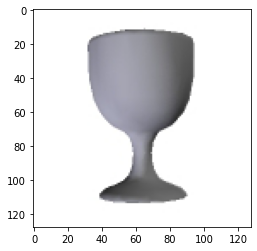

Similar Files Found: /content/3D Models/Modern-Glass/m502.obj,/content/3D Models/Modern-Glass/Y2440_GOBLET.obj, dissimilarity = 0.08717661207951305 
['/content/Thumbnails/Modern-Glass/M502.jpg']


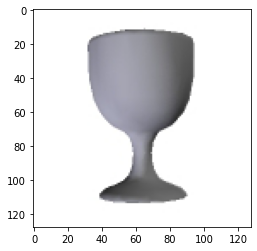

['/content/Thumbnails/Modern-Glass/Y2440_goblet.jpg']


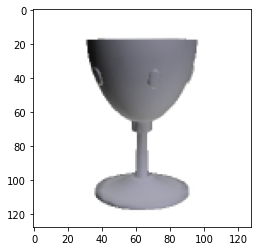

Similar Files Found: /content/3D Models/Modern-Glass/Y8979_glass1.obj,/content/3D Models/Modern-Glass/m501.obj, dissimilarity = 0.4105030626441505 
['/content/Thumbnails/Modern-Glass/Y8979_glass1.jpg']


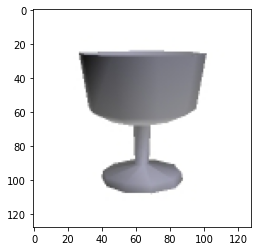

['/content/Thumbnails/Modern-Glass/M501.jpg']


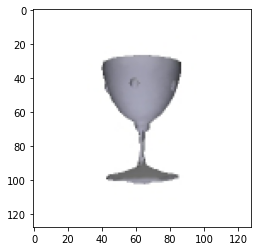

Similar Files Found: /content/3D Models/Modern-Glass/m501.obj,/content/3D Models/Modern-Glass/Vase8.obj, dissimilarity = 0.3981992231795072 
['/content/Thumbnails/Modern-Glass/M501.jpg']


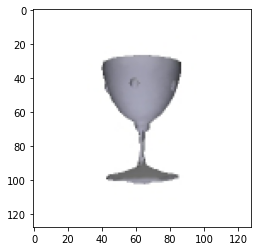

['/content/Thumbnails/Modern-Glass/Vase8.jpg']


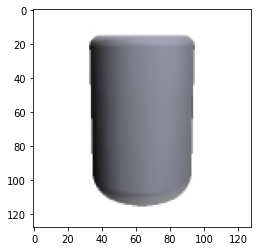

Similar Files Found: /content/3D Models/Modern-Glass/Glassn2.obj,/content/3D Models/Modern-Glass/Y2442_GRAIL.obj, dissimilarity = 0.08175987213397257 
['/content/Thumbnails/Modern-Glass/Glassn2.jpg']


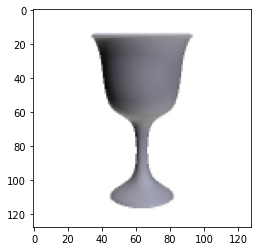

['/content/Thumbnails/Modern-Glass/Y2442_grail.jpg']


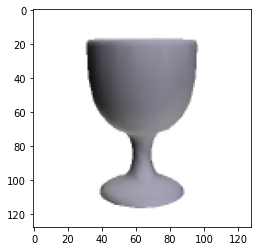

Similar Files Found: /content/3D Models/Modern-Glass/Y7979_goblet.obj,/content/3D Models/Modern-Glass/BlenderRepository_12-oz-glass.obj, dissimilarity = 0.3984167612346763 
['/content/Thumbnails/Modern-Glass/Y7979_goblet.jpg']


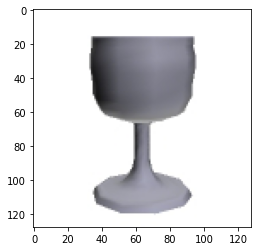

['/content/Thumbnails/Modern-Glass/Blenderrepository_12-oz-glass.jpg']


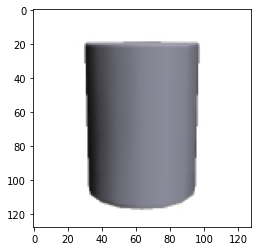

Similar Files Found: /content/3D Models/Modern-Glass/BlenderRepository_12-oz-glass.obj,/content/3D Models/Modern-Glass/Archive3D_Vase N290508.obj, dissimilarity = 0.005561096161711983 
['/content/Thumbnails/Modern-Glass/Blenderrepository_12-oz-glass.jpg']


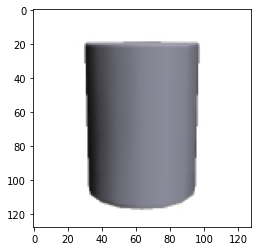

['/content/Thumbnails/Modern-Glass/Archive3d_vase n290508.jpg']


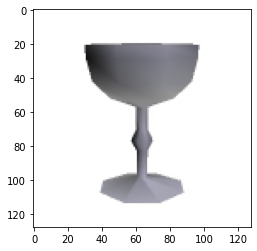

Similar Files Found: /content/3D Models/Modern-Glass/Archive3D_Vase N290508.obj,/content/3D Models/Modern-Glass/BlenderRepository_highball-glass.obj, dissimilarity = 0.4482070714167636 
['/content/Thumbnails/Modern-Glass/Archive3d_vase n290508.jpg']


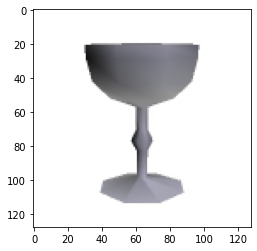

['/content/Thumbnails/Modern-Glass/Blenderrepository_highball-glass.jpg']


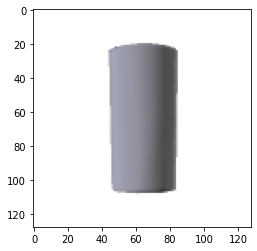

Similar Files Found: /content/3D Models/Modern-Glass/Y5100_CHAGLASS.obj,/content/3D Models/Modern-Glass/Y8985_goblet_g.obj, dissimilarity = 0.7866864649431414 
['/content/Thumbnails/Modern-Glass/Y5100_chaglass.jpg']


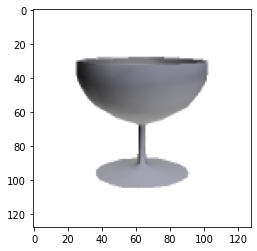

['/content/Thumbnails/Modern-Glass/Y8985_goblet_g.jpg']


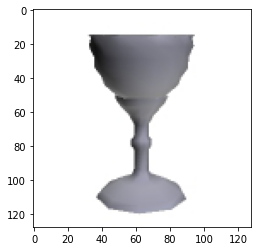

Similar Files Found: /content/3D Models/Modern-Glass/Y8985_goblet_g.obj,/content/3D Models/Modern-Glass/BlenderRepository_cocktail-glass.obj, dissimilarity = 0.28314634764058727 
['/content/Thumbnails/Modern-Glass/Y8985_goblet_g.jpg']


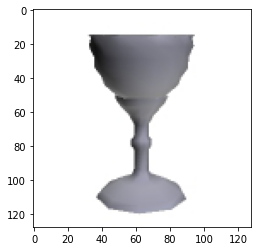

['/content/Thumbnails/Modern-Glass/Blenderrepository_cocktail-glass.jpg']


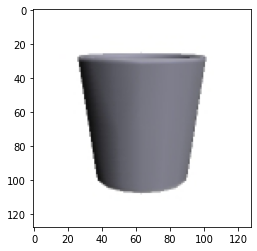

Similar Files Found: /content/3D Models/Modern-Glass/Y7976_glass3.obj,/content/3D Models/Modern-Glass/vase1s.obj, dissimilarity = 0.9804809358061026 
['/content/Thumbnails/Modern-Glass/Y7976_glass3.jpg']


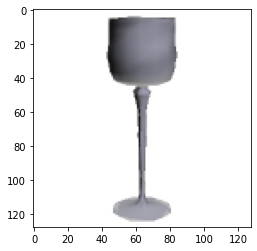

['/content/Thumbnails/Modern-Glass/Vase1s.jpg']


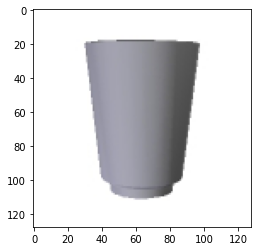

Similar Files Found: /content/3D Models/Modern-Glass/Y8079_Glass5.obj,/content/3D Models/Modern-Glass/m500.obj, dissimilarity = 0.45654258616804405 
['/content/Thumbnails/Modern-Glass/Y8079_glass5.jpg']


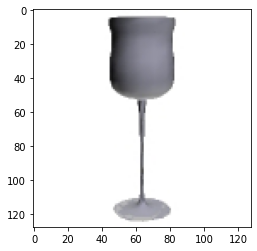

['/content/Thumbnails/Modern-Glass/M500.jpg']


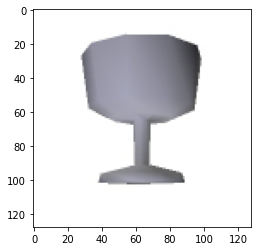

Similar Files Found: /content/3D Models/Modern-Glass/Y8980_glass2.obj,/content/3D Models/Modern-Glass/BlenderRepository_double-shot-glass.obj, dissimilarity = 0.29060212547608605 
['/content/Thumbnails/Modern-Glass/Y8980_glass2.jpg']


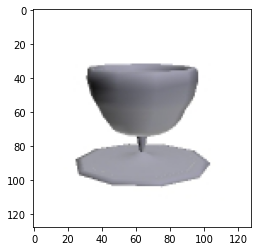

['/content/Thumbnails/Modern-Glass/Blenderrepository_double-shot-glass.jpg']


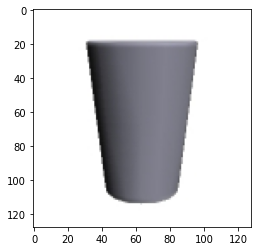

Similar Files Found: /content/3D Models/Modern-Glass/verre.obj,/content/3D Models/Modern-Glass/vase1.obj, dissimilarity = 0.921272566201286 
['/content/Thumbnails/Modern-Glass/Verre.jpg']


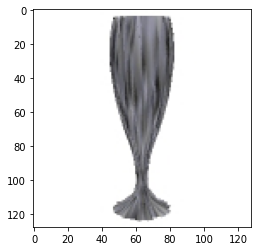

['/content/Thumbnails/Modern-Glass/Vase1.jpg']


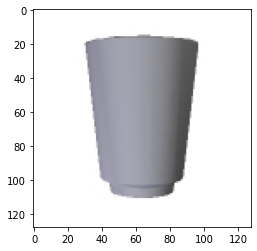

In [ ]:
treshold3 = 10
compare_feature_vectors_v3("/content/3D Models/Modern-Glass",treshold3)